# Clone precomputed models with SciPy heuristic estimators

In this notebook we will clone precomputed models with SciPy-based heuristic estimators such as `find_peaks`, `peak_prominences` and others.  This step should be considered a coarse first pass.

gully  
April 26, 2021

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import seaborn as sns
sns.set_context('paper', font_scale=2)

In [2]:
import torch
from blase.multiorder import MultiOrder
from blase.datasets import HPFDataset

In [3]:
import numpy as np
from scipy.signal import find_peaks, find_peaks_cwt, peak_prominences, peak_widths
from scipy.ndimage import gaussian_filter1d

In [4]:
device = "cpu"
data = HPFDataset("../test/data/Goldilocks_20191022T013208_v1.0_0003.spectra.fits")
model = MultiOrder(device=device, wl_data=data.data_cube[6, :, :])
spectrum = model.forward(5)

Let's take the natural log of the flux.

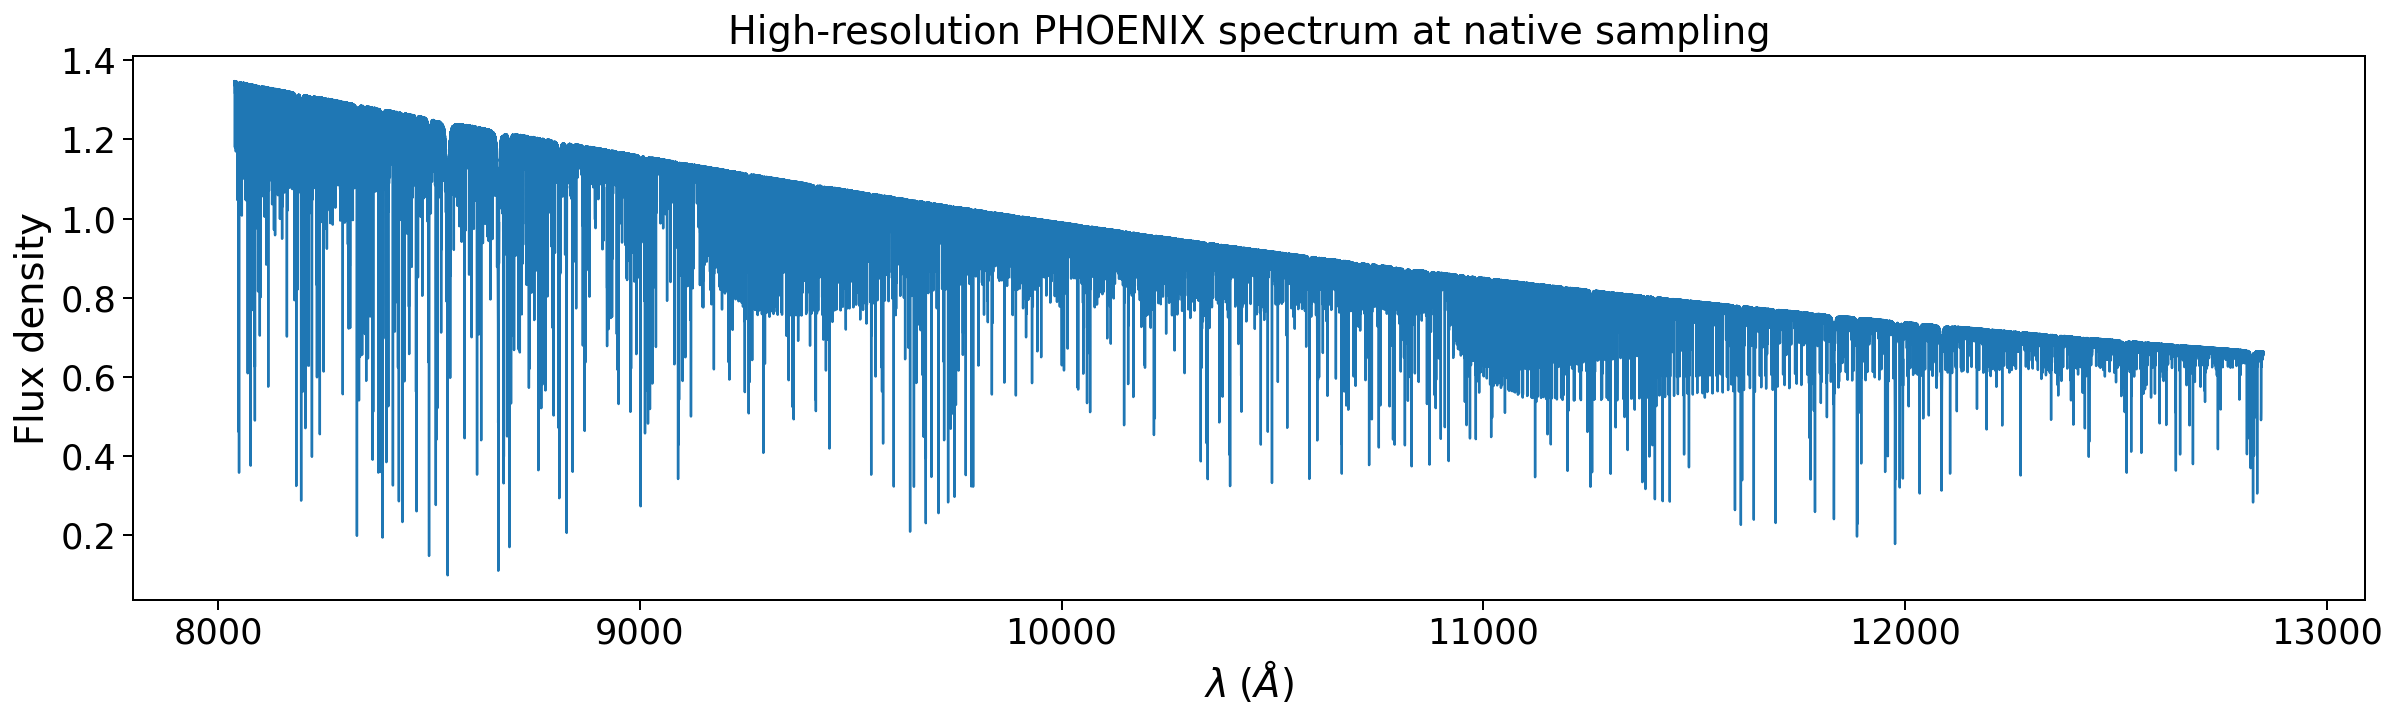

In [5]:
plt.figure(figsize=(20, 5))
plt.plot(model.wl_native, model.flux_native)
plt.xlabel('$\lambda \;(\AA)$')
plt.ylabel('Flux density')
plt.title('High-resolution PHOENIX spectrum at native sampling');

Our goal is to clone *most* of those lines.

In [6]:
smoothed_flux = gaussian_filtshoulder1d(model.flux_native.cpu(), sigma=10.0)

In [7]:
peaks, _ = find_peaks(-smoothed_flux, distance=10, prominence=0.05)

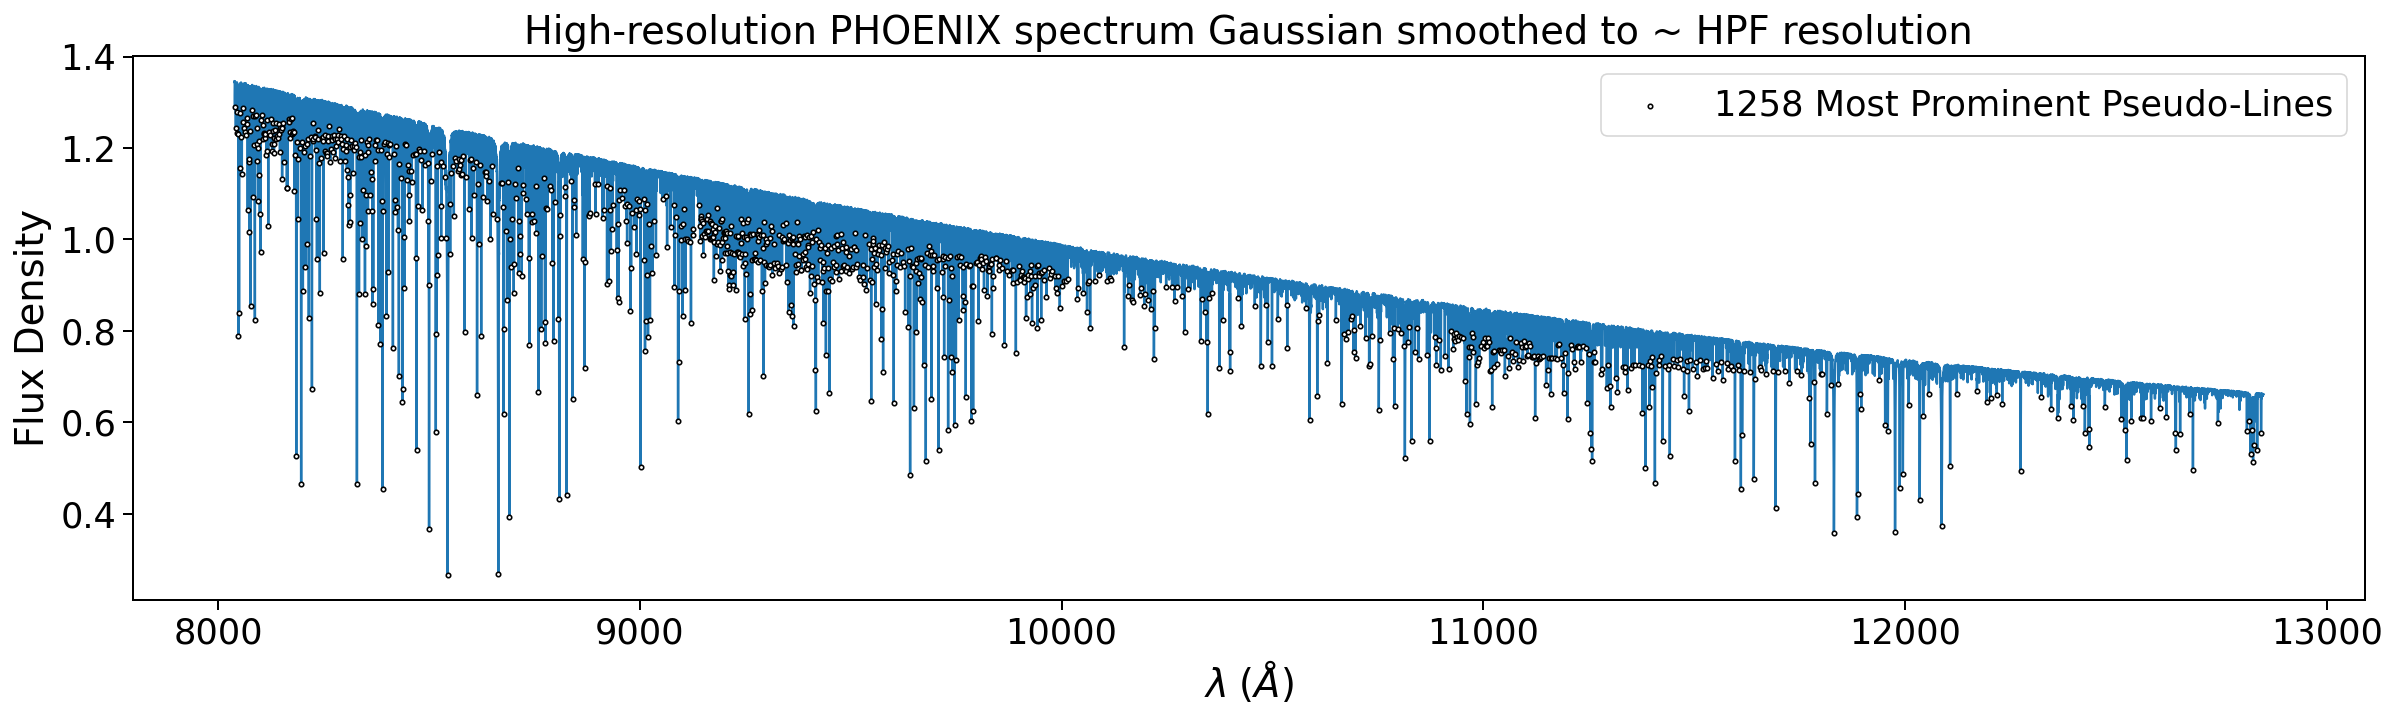

In [8]:
plt.figure(figsize=(20, 5))
plt.plot(model.wl_native, smoothed_flux)
plt.scatter(model.wl_native[peaks], smoothed_flux[peaks], marker='o', fc='w',ec='k', zorder=10, s=5,
         label='{:} Most Prominent Pseudo-Lines'.format(len(peaks)))
plt.xlabel('$\lambda \;(\AA)$')
plt.ylabel('Flux Density')
plt.title('High-resolution PHOENIX spectrum Gaussian smoothed to ~ HPF resolution')
plt.legend();

Ok, so we can probably reconstruct a decent predictive model of the spectrum with "only" ~1000 lines.

In [9]:
prominence_data = peak_prominences(-smoothed_flux, peaks)
width_data = peak_widths(-smoothed_flux, peaks, prominence_data=prominence_data)

In [10]:
prominences, left, right = prominence_data
widths, width_heights, left_ips, right_ips = width_data

Let's spot-check against real data to ensure that the cloned model resembles reality, even if coarsely.

In [11]:
wl = data.data_cube[6, 5, :]
flux = data.data_cube[0, 5, :]

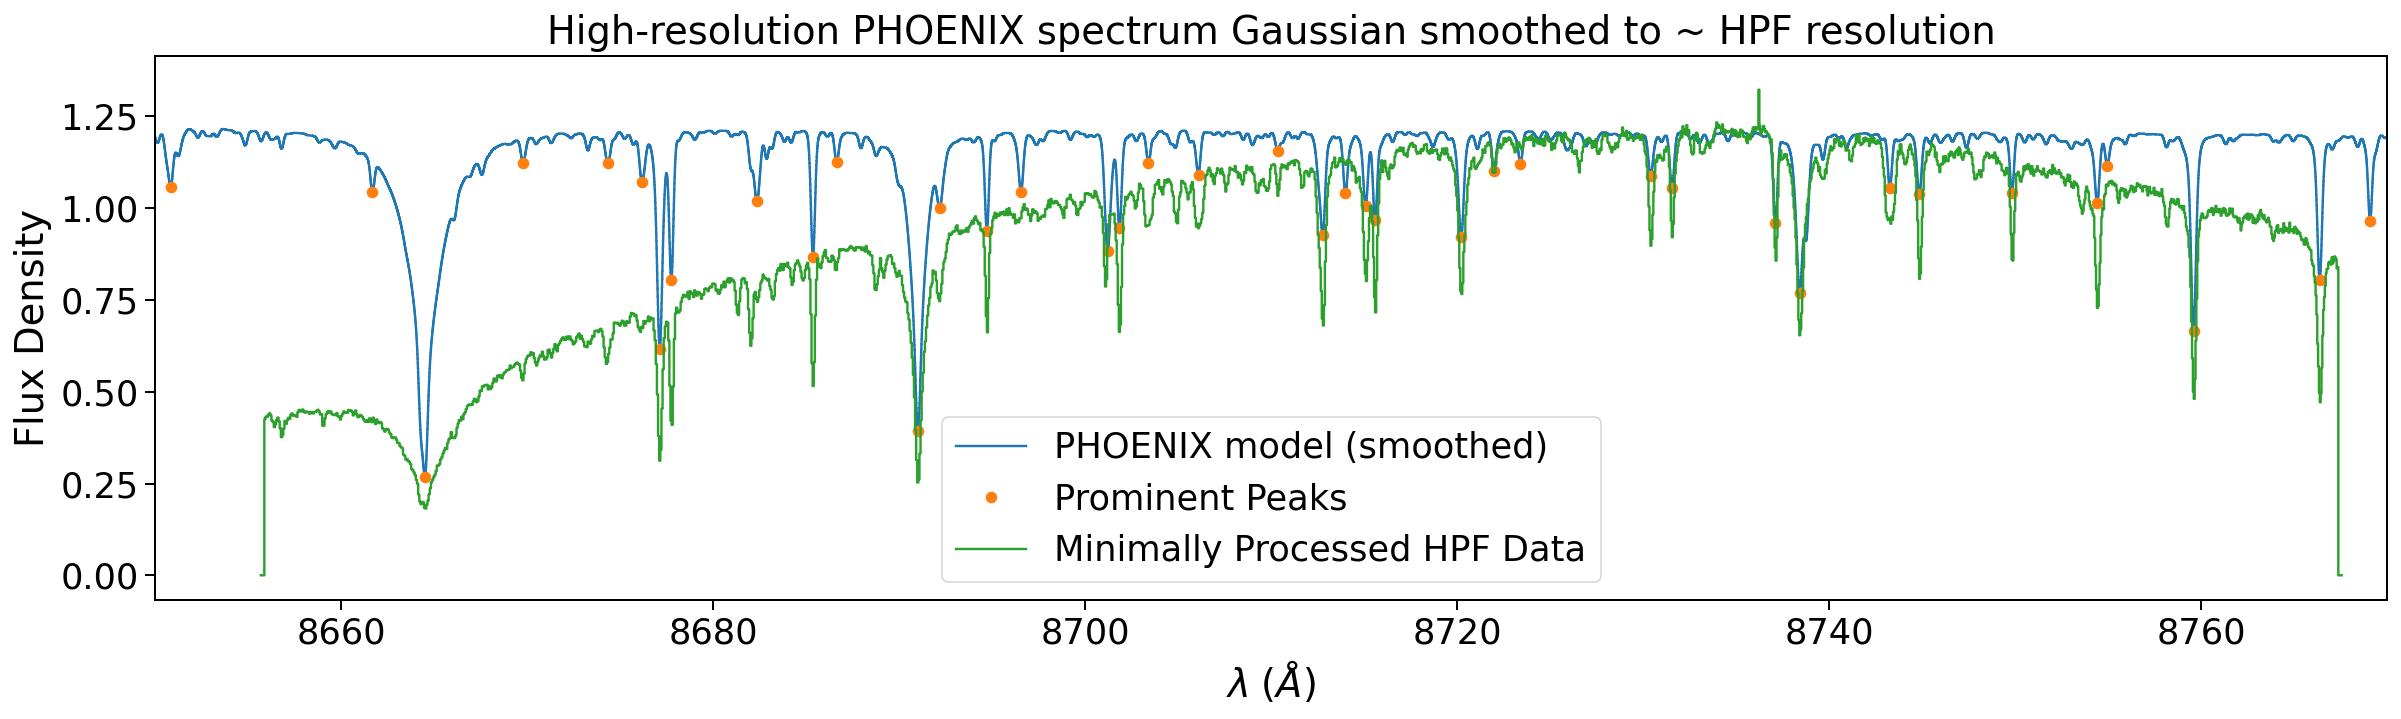

In [12]:
plt.figure(figsize=(20, 5))
plt.step(model.wl_native, smoothed_flux, label='PHOENIX model (smoothed)')
plt.step(model.wl_native[peaks], smoothed_flux[peaks], 'o', label='Prominent Peaks')
plt.step(wl-0.5, flux, label='Minimally Processed HPF Data')
plt.xlim(8650, 8770);
plt.xlabel('$\lambda \;(\AA)$')
plt.ylabel('Flux Density')
plt.title('High-resolution PHOENIX spectrum Gaussian smoothed to ~ HPF resolution')
plt.legend();

Awesome! We can replicate most of the structure seen in real data, if only the line strengths (and widths) were slightly different.  That's our goal (eventually)!  In the meantime, we need a function that takes in the signal-processed metadata and returns a decent initial guess.

In [13]:
def lorentzian_line(lam_center, width, amplitude, wavelengths):
    '''Return a Lorentzian line, given properties'''
    return amplitude/3.141592654 * width/(width**2 + (wavelengths - lam_center)**2)

In [14]:
def gaussian_line(lam_center, width, amplitude, wavelengths):
    '''Return a Gaussian line, given properties'''
    return amplitude/(width*torch.sqrt(torch.tensor(2*3.14159))) * torch.exp(-0.5*((wavelengths - lam_center) / width)**2)

In [15]:
lam_centers = model.wl_native[peaks]

Convert the FWHM in units of Angstroms: $$\sigma(Angstroms) = FWHM\frac{pixels}{1} \times \frac{Angstrom}{pixel} \times \frac{1}{2.355}$$

In [16]:
d_lam = np.diff(model.wl_native.cpu())[peaks]
widths_angs = torch.tensor(widths * d_lam / 2.355) * 0.83804203 *0.77116# Experimentally determined

The prominence scale factor may not be exactly 1.

In [17]:
prominence_scale_factor = 0.461*0.55736 # Experimentally determined
amplitudes = torch.tensor(prominences * prominence_scale_factor)

In [18]:
%%time
output = gaussian_line(lam_centers.unsqueeze(1), 
                          widths_angs.unsqueeze(1), 
                          amplitudes.unsqueeze(1), model.wl_native.unsqueeze(0))

CPU times: user 14.4 s, sys: 7.87 s, total: 22.2 s
Wall time: 3.71 s


In [19]:
%%time
output = lorentzian_line(lam_centers.unsqueeze(1), 
                          widths_angs.unsqueeze(1), 
                          amplitudes.unsqueeze(1), model.wl_native.unsqueeze(0))

CPU times: user 4.65 s, sys: 4.57 s, total: 9.22 s
Wall time: 1.54 s


In [20]:
net_spectrum = 1-output.sum(0)

Temporarily tilt the cloned model towards the smoothed spectrum and offset for clarity.

In [21]:
correction_factor = 1 - 0.41801511*(model.wl_native-9800)/3000

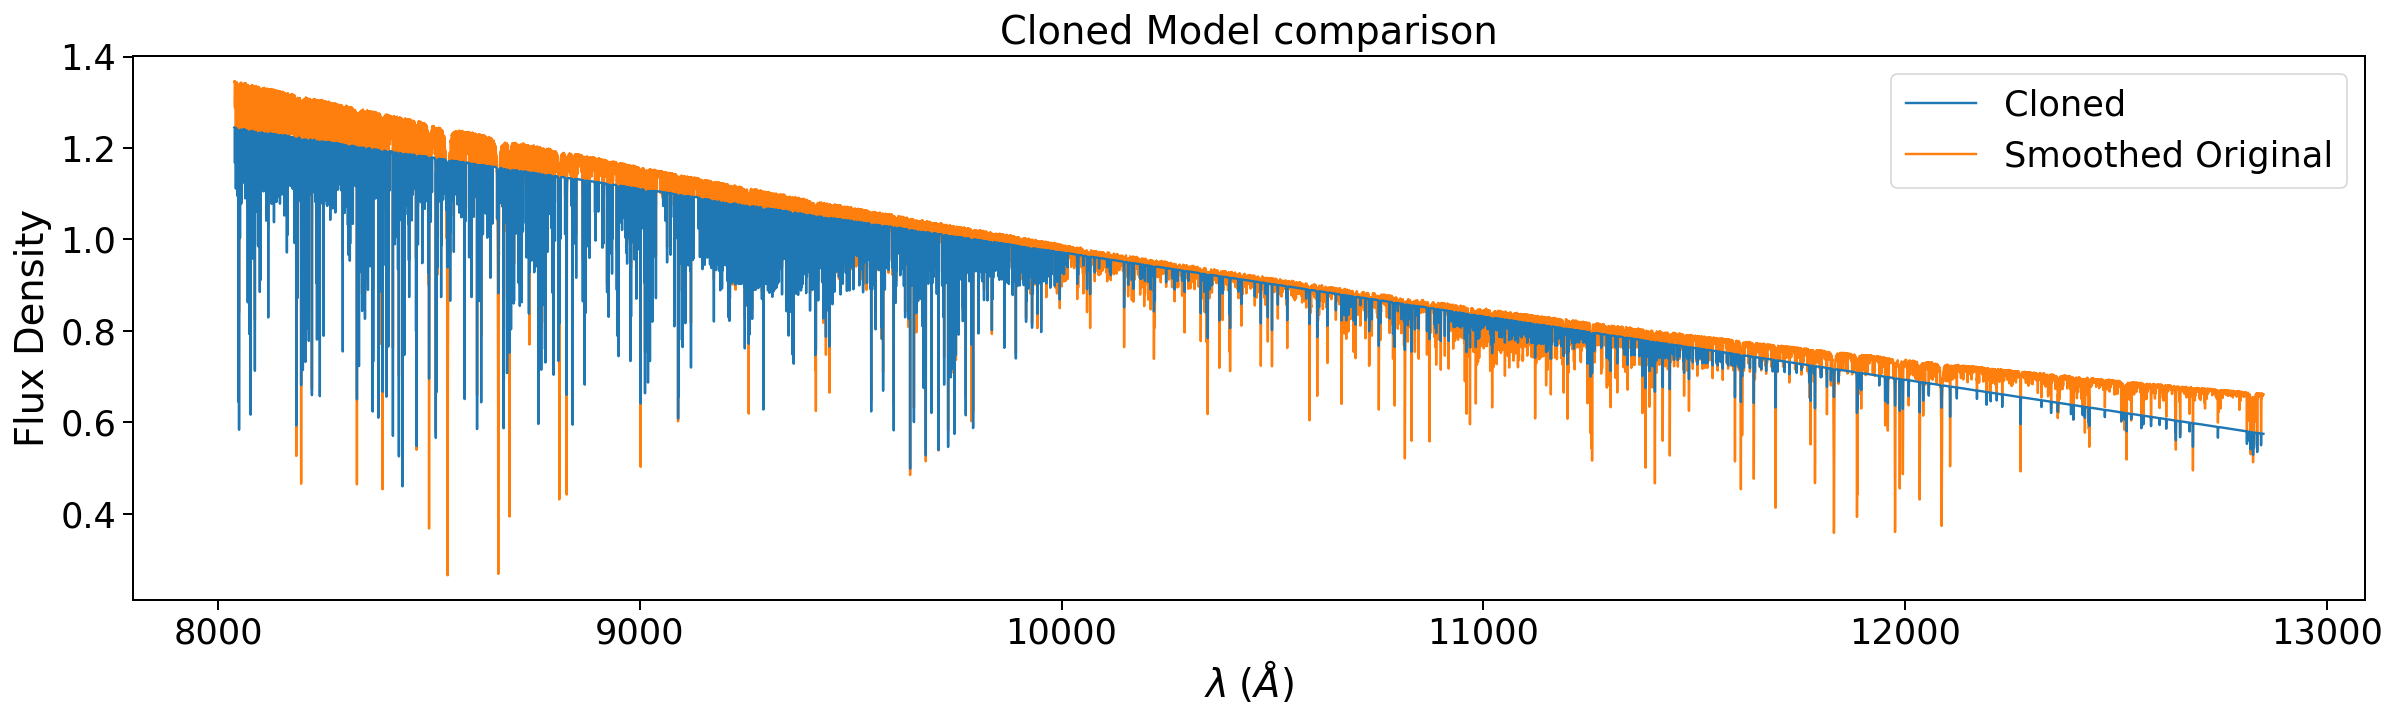

In [22]:
plt.figure(figsize=(20, 5))
plt.plot(model.wl_native, net_spectrum * correction_factor, label='Cloned', zorder=10)
plt.plot(model.wl_native, smoothed_flux, label='Smoothed Original')
plt.xlabel('$\lambda \;(\AA)$')
plt.ylabel('Flux Density')
plt.title('Cloned Model comparison')
plt.legend();

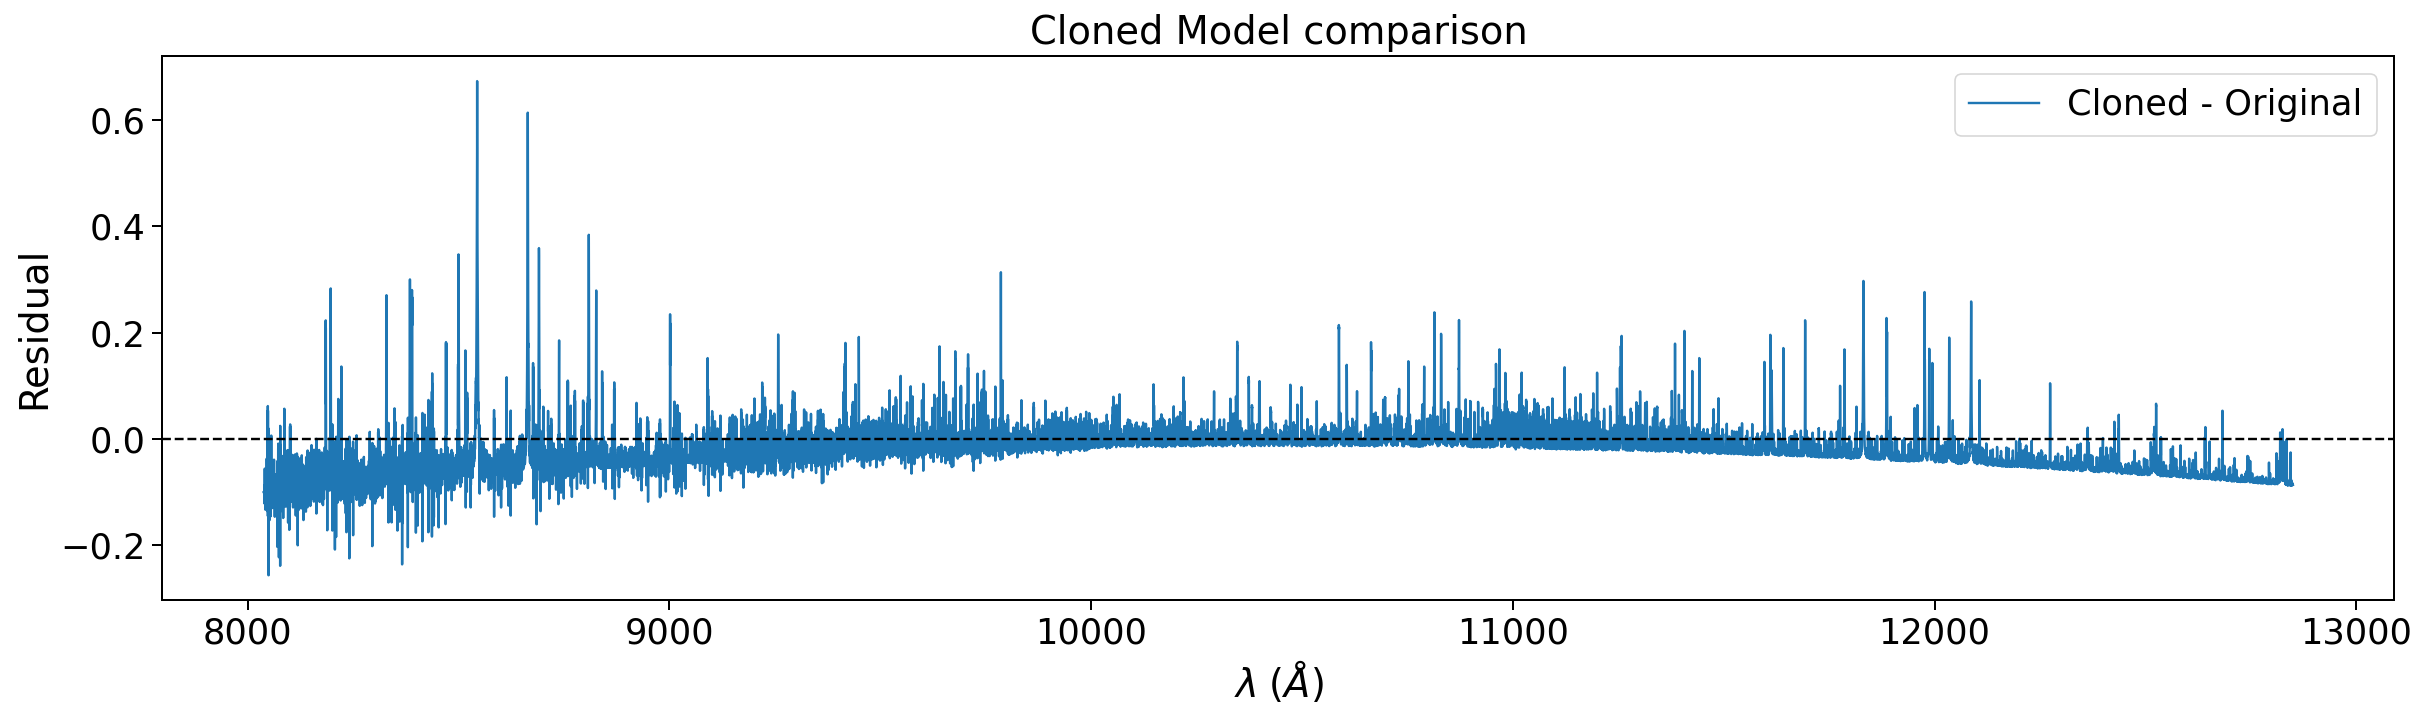

In [23]:
plt.figure(figsize=(20, 5))
plt.plot(model.wl_native, net_spectrum * correction_factor -smoothed_flux, label='Cloned - Original')
plt.xlabel('$\lambda \;(\AA)$')
plt.ylabel('Residual')
plt.title('Cloned Model comparison')
plt.axhline(0, color='k', linestyle='dashed')
plt.legend();

Not bad!  We have replicated some / most of the variance in the spectrum.  Let's attempt to tune our clone with a few knobs.

In [24]:
def goodness_of_fit_metric(params):
    prom_scale, width_scale, slope_factor = params
    output = lorentzian_line(lam_centers.unsqueeze(1), 
                          widths_angs.unsqueeze(1)*width_scale, 
                          amplitudes.unsqueeze(1)*prom_scale, 
                           model.wl_native.unsqueeze(0))
    net_spectrum = 1-output.sum(0)
    correction_factor = 1 - slope_factor*(model.wl_native-9800)/3000
    residual = net_spectrum * correction_factor - smoothed_flux
    return torch.sum(residual**2)

In [25]:
from scipy.optimize import minimize

In [26]:
%%time
result = minimize(goodness_of_fit_metric, [0.5, 1.0, 0.41])

CPU times: user 2min 56s, sys: 3min 5s, total: 6min 2s
Wall time: 1min 13s


In [27]:
result.x # array([0.46130227, 0.83804203, 0.41697805])

array([0.55736063, 0.77116275, 0.41811388])

Ok, that trick ever-so-slightly refines our clone, but only marginally so.

## Next steps:

1. Tune all of the ~1000 spectral lines simultaneously with Gradient Descent

2. Refine the lineshapes to include Lorentzian profile through direct Voigt convolution.

This last step may require a GPU!  In either case, we'll want to set up a PyTorch class to run the forward model.